# Feed-Forward Networks

**Processing attended information through MLPs**

After attention gathers information from across the sequence, we need to actually *process* that information. The feed-forward network (FFN) is a simple two-layer neural network—also called a Multi-Layer Perceptron (MLP)—that transforms each token's representation independently.

Think of attention as "communication" between tokens—gathering relevant context. The FFN is the "computation" step—processing that gathered information to extract useful features. Without the FFN, the model would only shuffle information around without transforming it.

## The Architecture

1. **Expand:** Project from `d_model` (e.g., 512) to `d_ff` (typically 4× larger, e.g., 2048). This expansion gives the model more "capacity" to learn complex patterns.

2. **Activate:** Apply GELU activation—a smooth nonlinear function that allows the model to learn non-linear relationships. Without this nonlinearity, stacking layers would be pointless (multiple linear transformations collapse to one).

3. **Project back:** Compress back down from `d_ff` to `d_model` so the output shape matches the input, allowing us to stack more layers.

**Position-wise:** The *same* FFN (same weights) is applied to every position independently. This is efficient and helps the model learn general transformations that work regardless of position.

In [1]:
import torch
import torch.nn as nn

class FeedForward(nn.Module):
    """Position-wise feed-forward network."""
    
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        
        # Expand dimension
        self.linear1 = nn.Linear(d_model, d_ff)
        
        # GELU activation (used in GPT-2, GPT-3)
        self.activation = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        
        # Project back to d_model
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(self, x):
        # x: (batch, seq_len, d_model)
        x = self.linear1(x)        # → (batch, seq_len, d_ff)
        x = self.activation(x)
        x = self.dropout1(x)
        x = self.linear2(x)        # → (batch, seq_len, d_model)
        x = self.dropout2(x)
        return x

In [2]:
# Example
d_model = 64
d_ff = 256  # 4× expansion
batch_size = 2
seq_len = 8

ffn = FeedForward(d_model, d_ff)

# Random input (imagine this came from attention)
x = torch.randn(batch_size, seq_len, d_model)
output = ffn(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"\nInternal expansion: {d_model} → {d_ff} → {d_model}")

Input shape: torch.Size([2, 8, 64])
Output shape: torch.Size([2, 8, 64])

Internal expansion: 64 → 256 → 64


## Division of Labor

Attention answers "What should I pay attention to?" while the FFN answers "Now that I have this information, what should I do with it?"

```
Token representations
        ↓
   [Attention]  ← "Gather relevant context"
        ↓
      [FFN]     ← "Process and transform"
        ↓
Richer representations
```

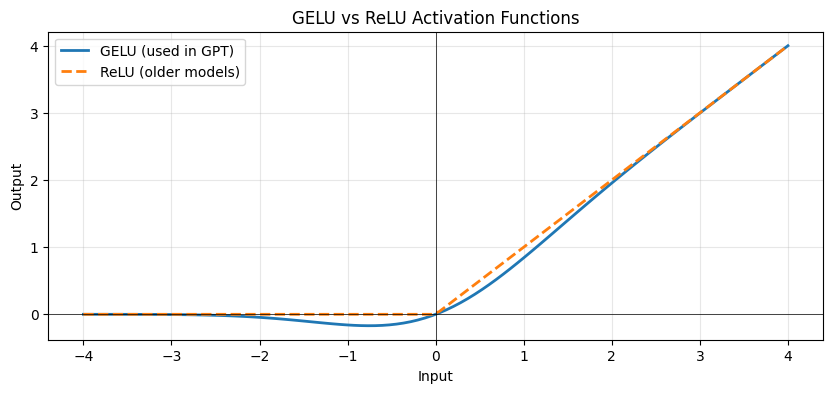

GELU is smooth near 0, allowing small negative values through.
This helps with gradient flow during training.


In [3]:
# Visualize GELU vs ReLU activation
import matplotlib.pyplot as plt
import numpy as np

x_vals = np.linspace(-4, 4, 100)

# GELU: x * Φ(x) where Φ is standard normal CDF
# Using the approximation: 0.5 * x * (1 + tanh(sqrt(2/π) * (x + 0.044715 * x^3)))
gelu = 0.5 * x_vals * (1 + np.tanh(np.sqrt(2 / np.pi) * (x_vals + 0.044715 * x_vals**3)))

# ReLU: max(0, x)
relu = np.maximum(0, x_vals)

plt.figure(figsize=(10, 4))
plt.plot(x_vals, gelu, label='GELU (used in GPT)', linewidth=2)
plt.plot(x_vals, relu, '--', label='ReLU (older models)', linewidth=2)
plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
plt.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('GELU vs ReLU Activation Functions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("GELU is smooth near 0, allowing small negative values through.")
print("This helps with gradient flow during training.")

In [4]:
# Count parameters
total_params = sum(p.numel() for p in ffn.parameters())
print(f"Feed-Forward Network Parameters:")
print(f"  linear1: {d_model} × {d_ff} + {d_ff} (bias) = {d_model * d_ff + d_ff:,}")
print(f"  linear2: {d_ff} × {d_model} + {d_model} (bias) = {d_ff * d_model + d_model:,}")
print(f"  Total: {total_params:,} parameters")
print(f"\nNote: FFN has ~2× more parameters than multi-head attention!")

Feed-Forward Network Parameters:
  linear1: 64 × 256 + 256 (bias) = 16,640
  linear2: 256 × 64 + 64 (bias) = 16,448
  Total: 33,088 parameters

Note: FFN has ~2× more parameters than multi-head attention!


## Next: Transformer Block

Now we'll combine attention and FFN with layer normalization and residual connections to create the complete transformer block.